<h2> Machine Learning for crop detection</h2>

In this notebook machine learning techniquey will be used to predict crops on fields based on their spectral signature. The "ground truth data" will be used from the [US Cropland Data Layer](https://nassgeodata.gmu.edu/CropScape/). From this layer the 5 most common crops for 2019 in the area of interest in North Dakota were chosen and downloaded as raster masks.

The training date will be Sentinel-2 data of 2019. The band 1-9 are being used.

A Decision Tree Classifier and a Random Forest Classifier will be trained on the data to see if the 9-band information is enough to classifiy the crops

In [2]:
# necessary Imports


import os
import numpy as np 
import geojson
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#import matplotlib.cm as cm
from IPython.display import Image

from helper_functions import RasterHelper
# geodata specific imports
import gdal
import rasterio
from rasterio.mask import mask

from geojson import Polygon

In [3]:


aoi= [{'type': 'Polygon', 'coordinates': [[[-10821406, 6029867], [-10821406, 6067979], [-10768297, 6067979], [-10768297, 6029867], [-10821406, 6029867]]]}]

In [4]:
croplist = ["Corn", "Dry_Beans" , "Soy_Beans", "Sugar_Beets", "Spring_Wheat"]

In [5]:
crop_arrays = []
for i, crop in enumerate(croplist):
    raster = rasterio.open(f'sample_data/NorthDakota/classification/{crop}_3857.tif')

    out_img, out_transform = mask(raster, shapes=aoi, crop=True)
    array = out_img[0]
    array = np.where(array == 0, np.nan, array)
    array = np.where(array == np.nanmean(array), i+1, np.nan)
    crop_arrays.append(array)

crop_array = np.array(crop_arrays)

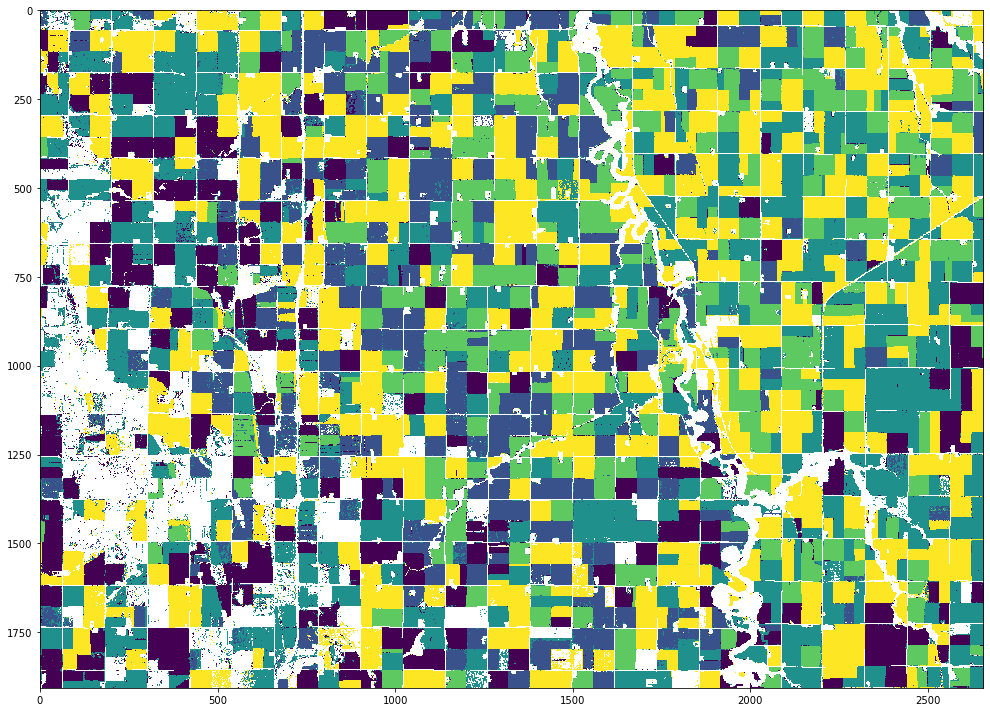

In [6]:
cropsum = np.nansum(crop_array, axis=0)
cropsum = np.where(cropsum == 0, np.nan, cropsum)
cropsum = cropsum[:,:-1]

fig, ax = plt.subplots(1, figsize=(20,10))
ax.imshow(cropsum)
plt.tight_layout()

In [7]:
cropsum.shape

(1907, 2656)

In [8]:
# open data sets

dir = "sample_data/NorthDakota/Sentinel"
# loop over directory and open all single band tiffs
helper = RasterHelper()
multiband_array = helper.open_multiband_scene(directory=dir, aoi=aoi)




Files were loaded sucessfully. 


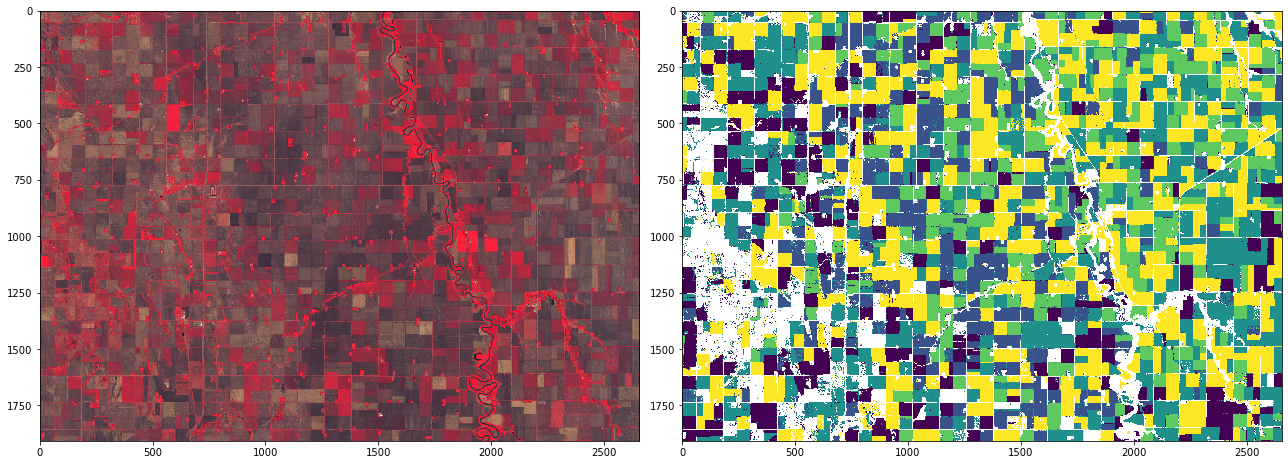

In [35]:


fig, (ax, ax2) = plt.subplots(1,2, figsize=(18,9))
#plot false color Vegetation image
ax.imshow(np.dstack([multiband_array[0][7],multiband_array[0][3],multiband_array[0][1]]), cmap="Greys")

#plot label array
ax2.imshow(cropsum)

plt.tight_layout()


<h2> Prepare data for Machine Learning</h2>

In [13]:
import pandas as pd

In [22]:
signature_array_June = multiband_array[0].T.reshape(-1,9)
signature_array_Sept = multiband_array[1].T.reshape(-1,9)
label_array = cropsum.T.reshape(-1,1)

In [44]:
df_1 = pd.DataFrame(signature_array_June, columns=['Jun_B1','Jun_B2','Jun_B3','Jun_B4','Jun_B5','Jun_B6','Jun_B7','Jun_B8','Jun_B9'])
df_2 = pd.DataFrame(signature_array_Sept, columns=['Sep_B1','Sep_B2','Sep_B3','Sep_B4','Sep_B5','Sep_B6','Sep_B7','Sep_B8','Sep_B9'])
label = pd.DataFrame(label_array, columns=['Label'])

In [45]:
df = pd.concat([df_1, df_2, label], axis=1)

In [46]:
df = df.dropna()
X = df.drop(['Label'], axis=1)
y = df["Label"]

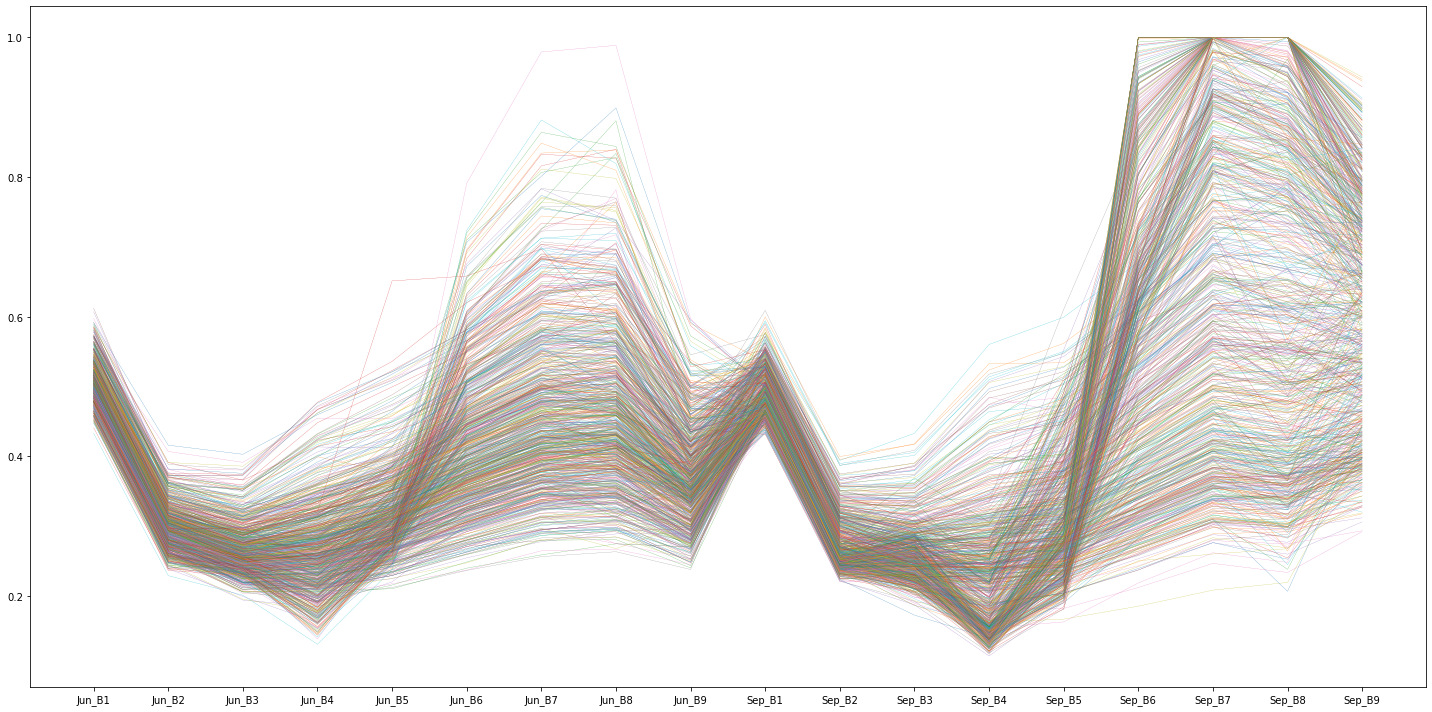

In [49]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(X.sample(n=800).T, linewidth=0.2)
plt.tight_layout()

In [33]:
clusters = np.reshape(np.array(df["Label"]), (cropsum.shape[1], cropsum.shape[0]))
cluster_img = np.flip(np.rot90(clusters, 3), 1)

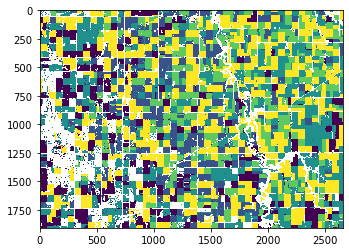

In [34]:
plt.imshow(cluster_img)